
### 1. Data reading


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize, train, plot_history, plot_confusion_matrix, compute_confusion_matrix

In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
Batch_Size = 64

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 2. View data (format, size, shape)


In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape 

(50000, 32, 32, 3)

In [8]:

print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>



### Summarize:

### 3. View pictures


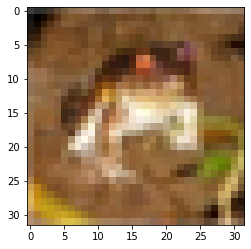

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

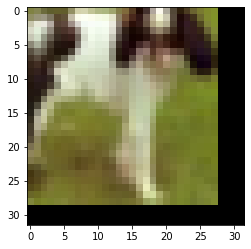

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

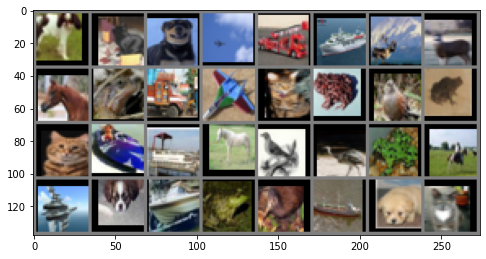

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# Define a convolution plus a relu activation function and a batchnorm as a basic layer structure
class BasicConv2d(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

In [16]:
class Inception(nn.Module):
    def __init__(self, in_channel, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(Inception, self).__init__()
        
        # first line
        self.branch1x1 = BasicConv2d(in_channel, n1x1, 1)
        
        # second line
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channel, n3x3red, 1),
            BasicConv2d(n3x3red, n3x3, 3, padding=1)
        )
        
        # third line
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channel, n5x5red, 1),
            BasicConv2d(n5x5red, n5x5, 5, padding=2)
        )
        
        # Fourth line
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channel, pool_proj, 1)
        )
    def forward(self, x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        output = torch.cat((f1, f2, f3, f4), dim=1)
        return output

In [17]:
class InceptionAux(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(InceptionAux, self).__init__()
#         self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.averagePool = nn.AvgPool2d(kernel_size=2)
        self.conv = BasicConv2d(in_channel, 128, kernel_size=1)  # output[batch, 128, 4, 4]
        
        self.fc1 = nn.Sequential(
#             nn.Linear(2048, 1024),
            nn.Linear(128,64),
            nn.ReLU(True)
        )
#         self.drop = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):

        x = self.averagePool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc1(x)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)
        return x

In [18]:
test_net = Inception(3, 64, 48, 64, 64, 96, 32)
test_x =torch.zeros(1, 3, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 32 x 32
output shape: 256 x 32 x 32


In [19]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channel, num_classes, aux_logits=False, verbose=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.verbose = verbose
        self.aux_logits = aux_logits
        

        # block1
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block2
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block3
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block4
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block5
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        
#         self.avgpool = nn.AvgPool2d(7)
        self.avgpool = nn.AvgPool2d(1) # 对32x32 不一样
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()
        
            
    def forward(self, x):
#         x = self.block1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
#         x = self.block2(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
#         x = self.block3(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
#         x = self.block4(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)
            if self.verbose:
                print('aux 1 output: {}'.format(aux1.shape))
            
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)
            if self.verbose:
                print('aux 2 output: {}'.format(aux2.shape))
        x = self.inception4e(x)
        x = self.maxpool4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
#         x = self.block5(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.classifier(x)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [20]:
net = GoogLeNet(3,10,aux_logits = True, verbose = False).to(device)

In [21]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
       BasicConv2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
       BasicConv2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
      BasicConv2d-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [22]:
print(net)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch): 

In [23]:
test_net = GoogLeNet(3, 10, aux_logits = True,verbose = True)
test_x = torch.zeros(3, 3, 32, 32)
test_net.train
test_y = test_net(test_x)
print('output: {}'.format(test_y[0].shape))

block 1 output: torch.Size([3, 64, 8, 8])
block 2 output: torch.Size([3, 192, 4, 4])
block 3 output: torch.Size([3, 480, 2, 2])
aux 1 output: torch.Size([3, 10])
aux 2 output: torch.Size([3, 10])
block 4 output: torch.Size([3, 832, 1, 1])
block 5 output: torch.Size([3, 1024, 1, 1])
output: torch.Size([3, 10])


In [24]:
net = GoogLeNet(3,10,aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True


### 5. Define the loss function and optimizer


In [25]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) 
import time
epoch = 50


### 6. Training

 If there is no accident, an error will be reported, because the input picture size in the 22-layer structure is 32x32, but in a series of intermediate calculations, the 32x32 picture size will appear in a certain link. The size of the calculation result is 0x0, so Mismatch.

 But in order to be the same as the paper, I changed all of them to 3x224x224 in the transform of the data, so no error will be reported.

 If we want to use 3x32x32, we may need to modify our average pooling layer

 I&#39;m using 32x32x3 here


In [26]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/GoogLeNet.pth'

The file already exists


In [27]:
import time
best_acc = 0
train_acc_list, test_acc_list = [],[]
train_loss_list, test_loss_list = [],[]
lr_list = []
for i in range(epoch):
    start = time.time()
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    if torch.cuda.is_available():
        net = net.to(device)
    net.train()
    for step,data in enumerate(trainloader,start=0):
        im,label = data
        im = im.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        logits, aux_logits2, aux_logits1 = net(im)
        loss0 = criterion(logits, label)
        loss1 = criterion(aux_logits1, label)
        loss2 = criterion(aux_logits2, label)
        loss = loss0 + loss1 *0.3 + loss2* 0.3
        loss.backward()
        optimizer.step()
        outputs = logits
        train_loss += loss.data
        probs, pred_y = outputs.data.max(dim=1) # get the probability
        train_acc += (pred_y==label).sum()/label.size(0)

        rate = (step + 1) / len(trainloader)
        a = "*"* int(rate *50)
        b = "."* (50 - int(rate *50))
        print('\r train {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc*100 / len(trainloader)
# print('train_loss:{:.3f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr = optimizer.param_groups[0]['lr']
    lr_list.append(lr)
    scheduler.step(train_loss)
    
    net.eval()
    with torch.no_grad():
        for step,data in enumerate(testloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)
            outputs = net(im)
            loss = criterion(outputs,label)
            test_loss += loss.data
            probs, pred_y = outputs.data.max(dim=1) # get the probability
            test_acc += (pred_y==label).sum()/label.size(0)
            rate = (step + 1) / len(testloader)
            a = "*" *int(rate* 50)
            b = "." *(50 - int(rate* 50))
            print('\r test {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')
    test_loss = test_loss / len(testloader)
    test_acc = test_acc* 100 /len(testloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    end = time.time()
    print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoch, train_loss, train_acc, test_loss, test_acc,lr), end='')
    time_= int(end - start)
    time_ = int(end - start)
    h = time_/ 3600
    m = time_% 3600/60
    s = time_% 60
    time_str = "\tTime %02d:%02d" % ( m, s)
    # print elapsed time
    print(time_str)
    # If you get better accuracy, save the model
    if test_acc > best_acc:
        torch.save(net,save_path)
        best_acc = test_acc

Acc = {}
Loss = {}
Acc['train_acc'] = train_acc_list
Acc['test_acc'] = test_acc_list
Loss['train_loss'] = train_loss_list
Loss['test_loss'] = test_loss_list
Lr = lr_list

Epoch [  1/ 50]  Train Loss:3.167579  Train Acc:32.80% Test Loss:1.679496  Test Acc:44.25%  Learning Rate:0.010000	Time 00:46
Epoch [  2/ 50]  Train Loss:2.530293  Train Acc:46.27% Test Loss:1.733470  Test Acc:53.25%  Learning Rate:0.010000	Time 00:45
Epoch [  3/ 50]  Train Loss:2.136976  Train Acc:54.79% Test Loss:1.285768  Test Acc:54.44%  Learning Rate:0.010000	Time 00:45
Epoch [  4/ 50]  Train Loss:1.860225  Train Acc:60.53% Test Loss:1.021073  Test Acc:64.66%  Learning Rate:0.010000	Time 00:45
Epoch [  5/ 50]  Train Loss:1.676558  Train Acc:64.80% Test Loss:0.887177  Test Acc:68.86%  Learning Rate:0.010000	Time 00:44
Epoch [  6/ 50]  Train Loss:1.541193  Train Acc:68.11% Test Loss:0.935749  Test Acc:67.20%  Learning Rate:0.010000	Time 00:45
Epoch [  7/ 50]  Train Loss:1.429482  Train Acc:70.60% Test Loss:0.819250  Test Acc:71.42%  Learning Rate:0.010000	Time 00:44
Epoch [  8/ 50]  Train Loss:1.350349  Train Acc:72.43% Test Loss:0.761165  Test Acc:73.60%  Learning Rate:0.010000	Tim

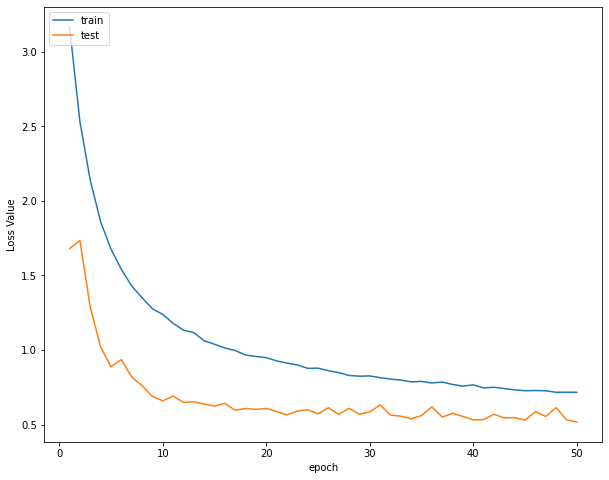

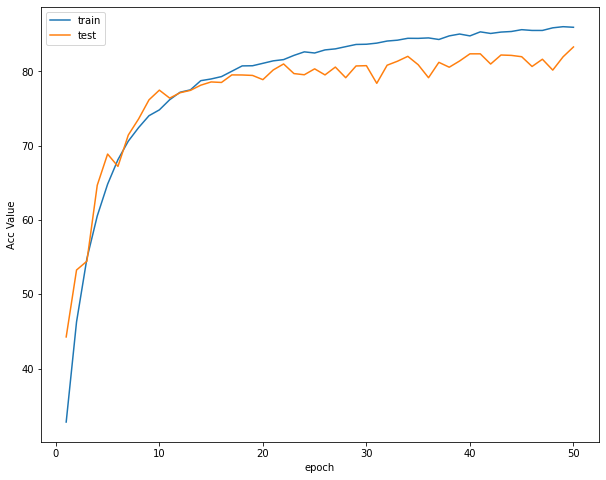

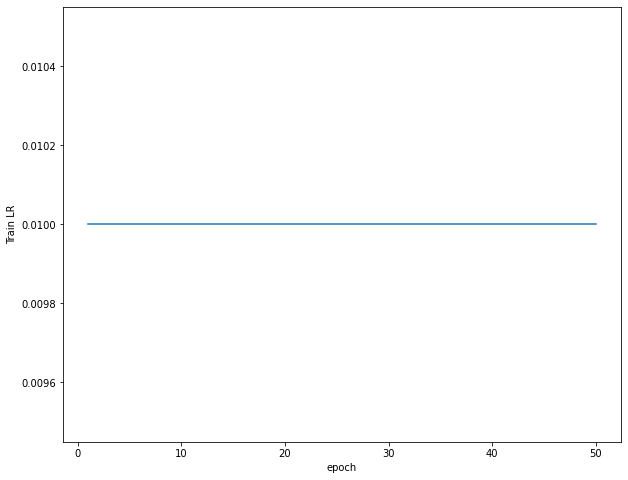

In [28]:
train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [i.to('cpu') for i in train_loss]
test_loss = [i.to('cpu') for i in test_loss]
train_acc = [i.to('cpu') for i in train_acc]
test_acc = [i.to('cpu') for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss
plot_history(epoch, Acc, Loss, Lr)


### 7. Test


In [30]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 83.22 %


In [31]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 86.90 %
Accuracy of automobile : 94.00 %
Accuracy of  bird : 81.70 %
Accuracy of   cat : 69.00 %
Accuracy of  deer : 80.10 %
Accuracy of   dog : 69.70 %
Accuracy of  frog : 91.70 %
Accuracy of horse : 79.80 %
Accuracy of  ship : 90.30 %
Accuracy of truck : 89.00 %


Accuracy Rate = 81.25%


<Figure size 1800x288 with 0 Axes>

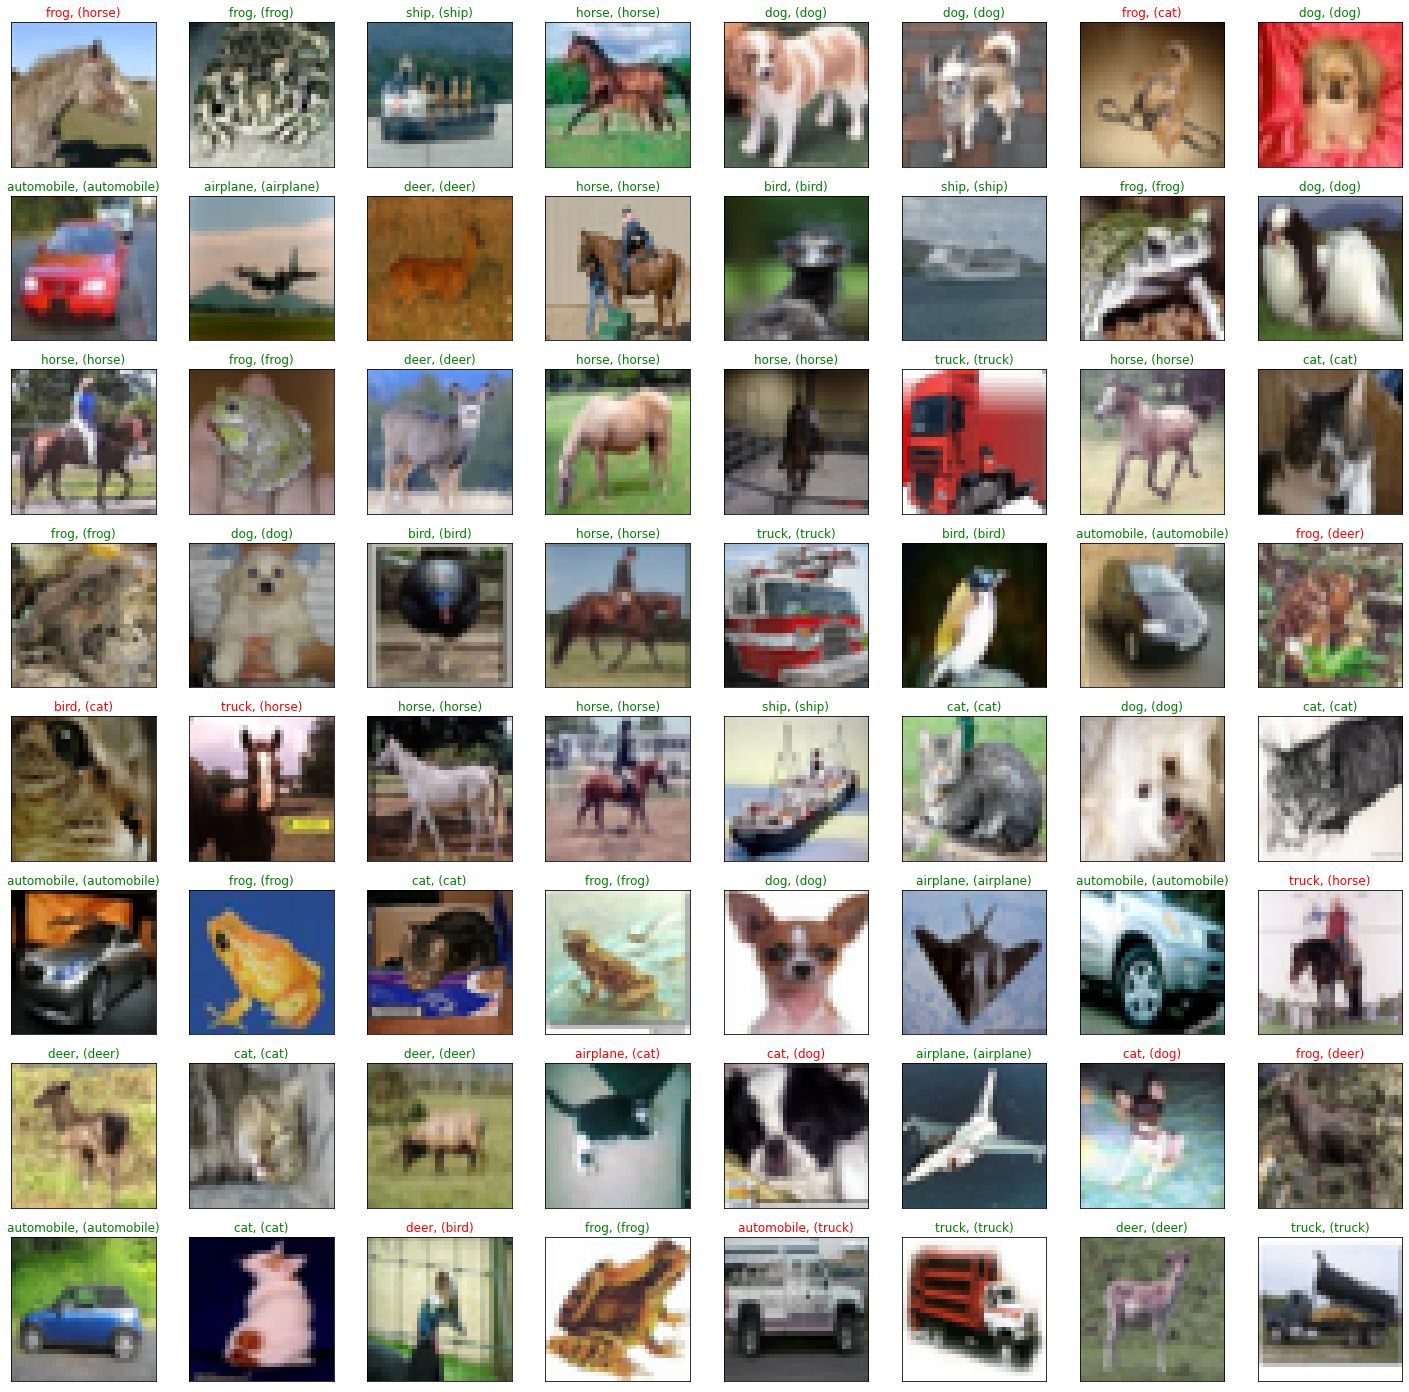

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

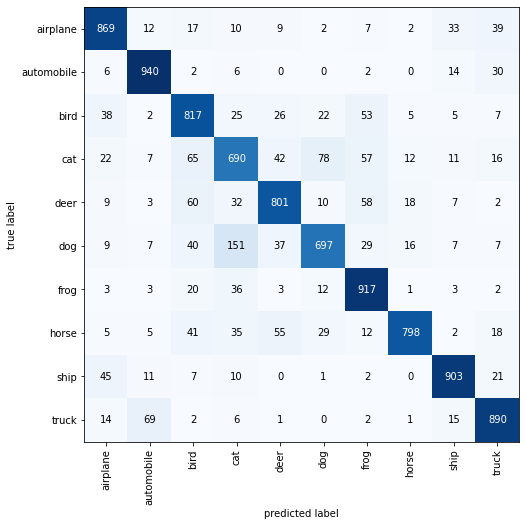

In [33]:
from utils import compute_confusion_matrix
from utils import plot_confusion_matrix

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

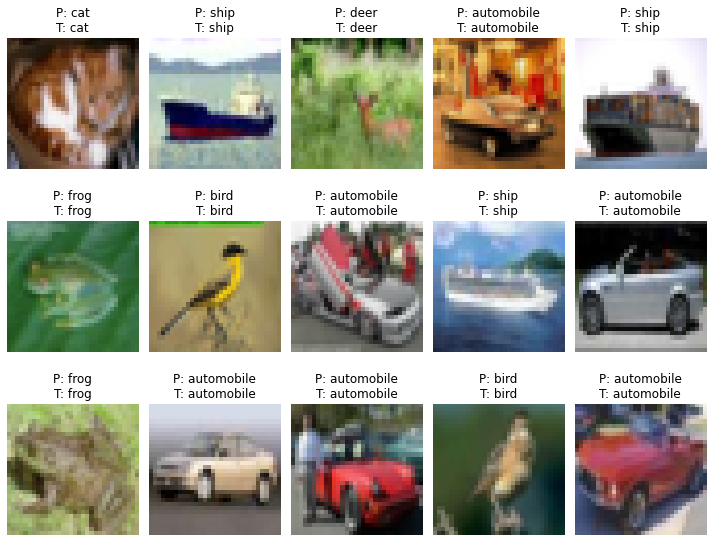

In [34]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

In [35]:
Acc

{'train_acc': [tensor(32.7965),
  tensor(46.2696),
  tensor(54.7874),
  tensor(60.5259),
  tensor(64.7978),
  tensor(68.1066),
  tensor(70.5962),
  tensor(72.4265),
  tensor(74.0209),
  tensor(74.8022),
  tensor(76.1729),
  tensor(77.1759),
  tensor(77.4976),
  tensor(78.7324),
  tensor(78.9622),
  tensor(79.2819),
  tensor(80.0032),
  tensor(80.7205),
  tensor(80.7405),
  tensor(81.0682),
  tensor(81.3999),
  tensor(81.5677),
  tensor(82.1351),
  tensor(82.6107),
  tensor(82.4568),
  tensor(82.8724),
  tensor(83.0123),
  tensor(83.3100),
  tensor(83.6057),
  tensor(83.6357),
  tensor(83.7856),
  tensor(84.0653),
  tensor(84.1812),
  tensor(84.4349),
  tensor(84.4249),
  tensor(84.4869),
  tensor(84.2751),
  tensor(84.7586),
  tensor(85.0104),
  tensor(84.7586),
  tensor(85.3021),
  tensor(85.0863),
  tensor(85.2721),
  tensor(85.3501),
  tensor(85.5958),
  tensor(85.4919),
  tensor(85.4919),
  tensor(85.8436),
  tensor(85.9974),
  tensor(85.9175)],
 'test_acc': [tensor(44.2476),
  ten


### 8. Save the model


In [ ]:
torch.save(net,save_path[:-4]+str(epoch)+'.pth')
# torch.save(net, './model/GoogLeNet-256.pth')